# Digit Generation with a G.A.N 

---

<img src="https://cdn-images-1.medium.com/max/800/1*4TJWlK-FPhskEIJshfEx5g.jpeg" style="width: 600px;"/>

Photo by [Eridy Lukau](https://towardsdatascience.com/@EridyLukau)


---

# Goal

This is not the 1st ambition of this [challenge](https://www.kaggle.com/c/digit-recognizer/), anyway generation of new digits can also be interesting !

Here i'm going to create a GAN model, to train this model, and then use it to generate new "handwritten" digits...

In [60]:
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#from keras.datasets import mnist

In [61]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [62]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Conv2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

## Credits

Thanks to [Antoine Meicler](https://github.com/ameicler) and [Vincent Vandenbussche](https://github.com/vincent-vdb) for all the things you teach me !

---

# Data preparation

We'll use the famous MNIST data intended to jearn computer vision fundamentals. 

In [63]:
df = pd.read_csv('../input/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
df['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

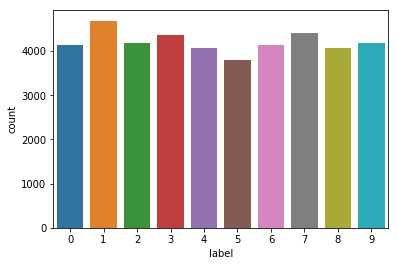

In [65]:
sns.countplot(df['label'])

They are 10 different classes which seem to be balanced.

In [66]:
X_train, y_train = np.array(df.iloc[:, 1:]), np.array(df['label'])
X_train.shape, y_train.shape

((42000, 784), (42000,))

In [68]:
img_width, img_height, channels = 28, 28, 1
X_train = X_train.reshape(42000, img_width, img_height, channels)
X_train.shape

(42000, 28, 28, 1)

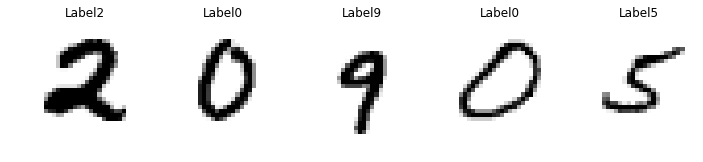

In [70]:
# display 5 randomly choosen images
plt.figure(figsize=(12, 5))

for i in range(1, 6):
    plt.subplot(1, 5, i)
    num = random.randint(0, X_train.shape[0])
    plt.imshow(X_train[num].reshape(img_width, img_height), cmap="gray_r")
    plt.axis('off')
    label = 'Label' + str(y_train[num])
    plt.title(label)

plt.show()

In [73]:
type(X_train[0, 0, 0, 0])

numpy.int64

In [74]:
# Rescale -1 to 1 and format the X_train dataset
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#X_train = np.expand_dims(X_train, axis=3)

Don't forget that the MNIST dataset is grayscale so it contains only one channel. 

Keras expects input images to have 3 dimensions even if there is only one channel.

---

# The GAN architecture

## Theory

<img src='https://cdn-images-1.medium.com/max/800/1*Fkdo567jgOrSHG49O90vCQ.png' style="width: 600px;"/>

Summary form [Towardsdatascience](https://towardsdatascience.com/image-generator-drawing-cartoons-with-generative-adversarial-networks-45e814ca9b6b)

We would like to provide a set of images as an input, and generate samples based on them as an output.

Input Images -> GAN -> Output Samples

With the following problem definition, GANs fall into the Unsupervised Learning bucket because we are not going to feed the model with labeled data.

_The underlying idea behind GAN is that it contains two neural networks that compete against each other in a zero-sum game framework, i.e. generator and a discriminator._


<img src='https://cdn-images-1.medium.com/max/800/1*JblpvnvQp1I5lL1-c9KsJw.png' style="width: 600px;"/>


__Generator__
The Generator takes random noise as an input and generates samples as an output. It’s goal is to generate such samples that will fool the Discriminator to think that it is seeing real images while actually seeing fakes. We can think of the Generator as a counterfeit.

__Discriminator__
Discriminator takes both real images from the input dataset and fake images from the Generator and outputs a verdict whether a given image is legit or not. We can think of the Discriminator as a policeman trying to catch the bad guys while letting the good guys free.

__Minimax Representation__
If we think once again about Discriminator’s and Generator’s goals, we can see that they are opposing each other. Discriminator’s success is a Generator’s failure and vice-versa. That is why we can represent GANs framework more like Minimax game framework rather than an optimization problem.

GAN data flow can be represented as in the following diagram.
<img src='https://cdn-images-1.medium.com/max/800/1*cxnqsjXYP-lx-3afYsuxXQ.png' style="width: 600px;"/>


## The Generator

The first step is to build a generator. We start with an **input noise shape of size 100**. Then, we create a sequential model to increase the size of the data up to 1024, before reshaping the data back to the input image shape.

Each layer will be made of:
- A **Dense layer** (sizes 256, 512, 1024 in order)
- A **LeakyRelu activation** with alpha = 0.2
- A **Batch normalization** (momentum = 0.8)

In [76]:
img_shape = (img_width, img_height, channels)

def build_generator():
    # Input Data
    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    
    # Create the sequential model
    model = Sequential()

    # Build the first layer
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Second layer
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Third layer
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Flatten and reshape
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    # Get model summary
    img = model(noise)
    model.summary()
    
    return Model(noise, img)

Compilation of the Generator and add an Adam optimizer as advised.

In [77]:
optimizer = Adam(0.0002, 0.5)
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 256)               1024      
_________________________________________________________________
dense_15 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_v1_10 (B (None, 512)               2048      
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312    
__________

## The Discriminator

Now let's build the discriminator. It takes an input that has the shape of the image. The steps are the following :
- Declaration of the **Sequential** model
- **Flatten** the images (with input shape = image shape)
- Addition of a **Dense layer** of 512 and a **Leaky Relu** (0.2)
- Addition of a **Dense layer** of 256 and a **Leaky Relu** (0.2)
- Addition of a **Dense layer** of size 1. What activation function would you use ?

In [78]:
def build_discriminator():
    
    img = Input(shape=img_shape)

    # Create the sequential model
    model = Sequential()
    
    # Flatten the images taken as inputs
    model.add(Flatten(input_shape=img_shape))
    
    # First layer
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    
    # Second layer
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
    # Last layer, return either 0 or 1
    model.add(Dense(1, activation='sigmoid'))
    
    # Get model summary
    validity = model(img)
    model.summary()
    
    return Model(img, validity)

Compilation of the discriminator. (Observe the metric we are using)

In [79]:
discriminator = build_discriminator()
discriminator.compile(
                loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


## Build the whole GAN model

It is time to build the entire **GAN model**. This operation can be achieved in 4 major steps :
- Declare the input
- Set the image as the result of the generator of the input
- Set the output as the result of the discriminator of the generated image
- Define and compile the model

In [80]:
# 1. Declare input of size (100, )
z = Input(shape=(100,))

# 2. Define the generated image from the input - Use the generator model compiled above
img = generator(z)

# 3. Define the output from the image - Use the discriminator model compiled above
valid = discriminator(img)

# For the combined model, only train the generator
discriminator.trainable = False

# 4.Combined model - by defining the input and the output
combined = Model(z, valid)

# Once created, compilation of the whole model
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Summary of the new model created.

In [81]:
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_3 (Model)              (None, 28, 28, 1)         1493520   
_________________________________________________________________
model_4 (Model)              (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


Function that is used to save generated images once in a while.

In [85]:
def save_imgs(epoch):
    
    # Predict from input noise
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Subplots
    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
 
    fig.savefig("../output/mnist_%d.png" % epoch)
    plt.close()

## Model Training

First of all, we set :
- the number of epochs the model will train to 15'000
- the batch size to 64
- the interval at which we save the images to 1000

In [86]:
epochs = 15000
batch_size = 64
save_interval = 1000
half_batch = int(batch_size / 2)

The following code is complete. Try to understand the different steps, debug potential errors from your previous code and compile it. 

In [87]:
d_loss_hist = []
g_loss_hist = []
d_acc = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Pick 50% of sample images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    # Generate 50% of new images
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)
    
    
    # Train discriminator on real images with label 1
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    
    # Train discriminator on fake images with label 0
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    
    # Loss of discriminator = Mean of Real and Fake loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    d_loss_hist.append(d_loss[0])
    d_acc.append(d_loss[1])
    
    # ---------------------
    #  Train Generator
    # ---------------------

    # The generator wants the discriminator to label the generated samples as valid (ones)
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
    g_loss_hist.append(g_loss)
    
    # Print the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        
    if epoch % save_interval == 0:
        save_imgs(epoch)

0 [D loss: 0.374034, acc.: 81.25%] [G loss: 0.722144]
1 [D loss: 0.339896, acc.: 81.25%] [G loss: 0.761038]
2 [D loss: 0.347759, acc.: 81.25%] [G loss: 0.847006]
3 [D loss: 0.334043, acc.: 81.25%] [G loss: 0.955707]
4 [D loss: 0.314673, acc.: 87.50%] [G loss: 1.075714]
5 [D loss: 0.272925, acc.: 90.62%] [G loss: 1.225585]
6 [D loss: 0.217444, acc.: 98.44%] [G loss: 1.306365]
7 [D loss: 0.205875, acc.: 100.00%] [G loss: 1.505471]
8 [D loss: 0.172943, acc.: 100.00%] [G loss: 1.633218]
9 [D loss: 0.144670, acc.: 100.00%] [G loss: 1.828782]
10 [D loss: 0.122131, acc.: 100.00%] [G loss: 1.955405]
11 [D loss: 0.097202, acc.: 100.00%] [G loss: 2.050833]
12 [D loss: 0.094377, acc.: 100.00%] [G loss: 2.157885]
13 [D loss: 0.082262, acc.: 100.00%] [G loss: 2.301859]
14 [D loss: 0.059196, acc.: 100.00%] [G loss: 2.409838]
15 [D loss: 0.066169, acc.: 100.00%] [G loss: 2.451670]
16 [D loss: 0.052666, acc.: 100.00%] [G loss: 2.431440]
17 [D loss: 0.060274, acc.: 100.00%] [G loss: 2.637853]
18 [D los

141 [D loss: 0.331948, acc.: 85.94%] [G loss: 2.520603]
142 [D loss: 0.163156, acc.: 95.31%] [G loss: 2.874989]
143 [D loss: 0.119477, acc.: 98.44%] [G loss: 2.935562]
144 [D loss: 0.198312, acc.: 92.19%] [G loss: 2.814238]
145 [D loss: 0.153139, acc.: 93.75%] [G loss: 3.016881]
146 [D loss: 0.193184, acc.: 95.31%] [G loss: 3.426831]
147 [D loss: 0.370926, acc.: 82.81%] [G loss: 2.197929]
148 [D loss: 0.235763, acc.: 82.81%] [G loss: 3.859068]
149 [D loss: 0.377793, acc.: 85.94%] [G loss: 2.279947]
150 [D loss: 0.313458, acc.: 81.25%] [G loss: 3.813969]
151 [D loss: 0.568598, acc.: 71.88%] [G loss: 2.520046]
152 [D loss: 0.237637, acc.: 85.94%] [G loss: 3.603076]
153 [D loss: 0.526246, acc.: 75.00%] [G loss: 2.010391]
154 [D loss: 0.201519, acc.: 92.19%] [G loss: 2.745867]
155 [D loss: 0.179433, acc.: 96.88%] [G loss: 3.379988]
156 [D loss: 0.444769, acc.: 78.12%] [G loss: 1.999989]
157 [D loss: 0.313832, acc.: 82.81%] [G loss: 3.312857]
158 [D loss: 0.437392, acc.: 81.25%] [G loss: 2.

293 [D loss: 0.741845, acc.: 42.19%] [G loss: 0.625492]
294 [D loss: 0.694660, acc.: 46.88%] [G loss: 0.618670]
295 [D loss: 0.725728, acc.: 45.31%] [G loss: 0.614347]
296 [D loss: 0.733593, acc.: 43.75%] [G loss: 0.625035]
297 [D loss: 0.697867, acc.: 45.31%] [G loss: 0.635558]
298 [D loss: 0.689688, acc.: 48.44%] [G loss: 0.634025]
299 [D loss: 0.740147, acc.: 35.94%] [G loss: 0.616251]
300 [D loss: 0.705789, acc.: 43.75%] [G loss: 0.636136]
301 [D loss: 0.686312, acc.: 43.75%] [G loss: 0.657210]
302 [D loss: 0.720498, acc.: 42.19%] [G loss: 0.631200]
303 [D loss: 0.702479, acc.: 43.75%] [G loss: 0.624545]
304 [D loss: 0.686460, acc.: 50.00%] [G loss: 0.634534]
305 [D loss: 0.702960, acc.: 39.06%] [G loss: 0.622379]
306 [D loss: 0.683358, acc.: 45.31%] [G loss: 0.635741]
307 [D loss: 0.717015, acc.: 39.06%] [G loss: 0.625899]
308 [D loss: 0.728248, acc.: 43.75%] [G loss: 0.620369]
309 [D loss: 0.686070, acc.: 48.44%] [G loss: 0.616639]
310 [D loss: 0.694937, acc.: 45.31%] [G loss: 0.

443 [D loss: 0.666494, acc.: 50.00%] [G loss: 0.669882]
444 [D loss: 0.666623, acc.: 48.44%] [G loss: 0.664829]
445 [D loss: 0.663619, acc.: 50.00%] [G loss: 0.666255]
446 [D loss: 0.665950, acc.: 48.44%] [G loss: 0.664327]
447 [D loss: 0.658748, acc.: 53.12%] [G loss: 0.662893]
448 [D loss: 0.667401, acc.: 51.56%] [G loss: 0.669386]
449 [D loss: 0.665385, acc.: 50.00%] [G loss: 0.691195]
450 [D loss: 0.657733, acc.: 50.00%] [G loss: 0.707041]
451 [D loss: 0.668148, acc.: 48.44%] [G loss: 0.698927]
452 [D loss: 0.662660, acc.: 48.44%] [G loss: 0.698525]
453 [D loss: 0.648846, acc.: 50.00%] [G loss: 0.698650]
454 [D loss: 0.632200, acc.: 54.69%] [G loss: 0.720985]
455 [D loss: 0.680060, acc.: 48.44%] [G loss: 0.708475]
456 [D loss: 0.648712, acc.: 60.94%] [G loss: 0.715189]
457 [D loss: 0.643925, acc.: 62.50%] [G loss: 0.738580]
458 [D loss: 0.664517, acc.: 54.69%] [G loss: 0.727627]
459 [D loss: 0.666492, acc.: 54.69%] [G loss: 0.714767]
460 [D loss: 0.655792, acc.: 54.69%] [G loss: 0.

591 [D loss: 0.612313, acc.: 70.31%] [G loss: 0.752882]
592 [D loss: 0.622905, acc.: 71.88%] [G loss: 0.727003]
593 [D loss: 0.639839, acc.: 60.94%] [G loss: 0.719597]
594 [D loss: 0.632815, acc.: 62.50%] [G loss: 0.726001]
595 [D loss: 0.645377, acc.: 57.81%] [G loss: 0.729570]
596 [D loss: 0.629939, acc.: 65.62%] [G loss: 0.718722]
597 [D loss: 0.635174, acc.: 57.81%] [G loss: 0.709989]
598 [D loss: 0.641536, acc.: 59.38%] [G loss: 0.725796]
599 [D loss: 0.642807, acc.: 56.25%] [G loss: 0.723678]
600 [D loss: 0.664899, acc.: 59.38%] [G loss: 0.696975]
601 [D loss: 0.648372, acc.: 67.19%] [G loss: 0.706953]
602 [D loss: 0.670171, acc.: 57.81%] [G loss: 0.723573]
603 [D loss: 0.649983, acc.: 64.06%] [G loss: 0.740344]
604 [D loss: 0.684433, acc.: 59.38%] [G loss: 0.767126]
605 [D loss: 0.667106, acc.: 65.62%] [G loss: 0.753068]
606 [D loss: 0.667374, acc.: 53.12%] [G loss: 0.737822]
607 [D loss: 0.654807, acc.: 59.38%] [G loss: 0.740990]
608 [D loss: 0.654646, acc.: 54.69%] [G loss: 0.

742 [D loss: 0.665305, acc.: 54.69%] [G loss: 0.824371]
743 [D loss: 0.611763, acc.: 67.19%] [G loss: 0.853380]
744 [D loss: 0.627538, acc.: 73.44%] [G loss: 0.842994]
745 [D loss: 0.607432, acc.: 73.44%] [G loss: 0.849088]
746 [D loss: 0.627679, acc.: 75.00%] [G loss: 0.862395]
747 [D loss: 0.628327, acc.: 73.44%] [G loss: 0.796187]
748 [D loss: 0.626750, acc.: 64.06%] [G loss: 0.777103]
749 [D loss: 0.648635, acc.: 64.06%] [G loss: 0.806079]
750 [D loss: 0.665515, acc.: 60.94%] [G loss: 0.819882]
751 [D loss: 0.638545, acc.: 68.75%] [G loss: 0.814630]
752 [D loss: 0.654693, acc.: 64.06%] [G loss: 0.825884]
753 [D loss: 0.621492, acc.: 59.38%] [G loss: 0.831760]
754 [D loss: 0.661777, acc.: 56.25%] [G loss: 0.830667]
755 [D loss: 0.642259, acc.: 56.25%] [G loss: 0.775482]
756 [D loss: 0.649082, acc.: 70.31%] [G loss: 0.777438]
757 [D loss: 0.660070, acc.: 62.50%] [G loss: 0.771879]
758 [D loss: 0.627775, acc.: 60.94%] [G loss: 0.764967]
759 [D loss: 0.654045, acc.: 57.81%] [G loss: 0.

892 [D loss: 0.587618, acc.: 81.25%] [G loss: 0.846606]
893 [D loss: 0.622282, acc.: 60.94%] [G loss: 0.845699]
894 [D loss: 0.655516, acc.: 54.69%] [G loss: 0.825090]
895 [D loss: 0.627424, acc.: 59.38%] [G loss: 0.850587]
896 [D loss: 0.635832, acc.: 57.81%] [G loss: 0.896528]
897 [D loss: 0.644801, acc.: 65.62%] [G loss: 0.834066]
898 [D loss: 0.601777, acc.: 62.50%] [G loss: 0.861044]
899 [D loss: 0.616297, acc.: 75.00%] [G loss: 0.864978]
900 [D loss: 0.629659, acc.: 67.19%] [G loss: 0.855358]
901 [D loss: 0.639196, acc.: 60.94%] [G loss: 0.891363]
902 [D loss: 0.654434, acc.: 56.25%] [G loss: 0.823164]
903 [D loss: 0.629575, acc.: 60.94%] [G loss: 0.844714]
904 [D loss: 0.606215, acc.: 75.00%] [G loss: 0.853475]
905 [D loss: 0.654629, acc.: 53.12%] [G loss: 0.848755]
906 [D loss: 0.608807, acc.: 70.31%] [G loss: 0.852291]
907 [D loss: 0.612965, acc.: 73.44%] [G loss: 0.834382]
908 [D loss: 0.630073, acc.: 65.62%] [G loss: 0.834650]
909 [D loss: 0.631194, acc.: 60.94%] [G loss: 0.

1041 [D loss: 0.610315, acc.: 64.06%] [G loss: 0.891164]
1042 [D loss: 0.623366, acc.: 70.31%] [G loss: 0.900202]
1043 [D loss: 0.595668, acc.: 70.31%] [G loss: 0.903952]
1044 [D loss: 0.647255, acc.: 67.19%] [G loss: 0.958154]
1045 [D loss: 0.617751, acc.: 64.06%] [G loss: 0.961969]
1046 [D loss: 0.618701, acc.: 64.06%] [G loss: 0.956466]
1047 [D loss: 0.570547, acc.: 79.69%] [G loss: 1.022736]
1048 [D loss: 0.661716, acc.: 54.69%] [G loss: 0.996487]
1049 [D loss: 0.623167, acc.: 65.62%] [G loss: 0.937686]
1050 [D loss: 0.623806, acc.: 62.50%] [G loss: 1.015948]
1051 [D loss: 0.619801, acc.: 68.75%] [G loss: 1.059737]
1052 [D loss: 0.640261, acc.: 67.19%] [G loss: 0.986187]
1053 [D loss: 0.651493, acc.: 62.50%] [G loss: 0.967386]
1054 [D loss: 0.617492, acc.: 68.75%] [G loss: 0.944532]
1055 [D loss: 0.596407, acc.: 81.25%] [G loss: 1.053797]
1056 [D loss: 0.556186, acc.: 82.81%] [G loss: 1.052465]
1057 [D loss: 0.597524, acc.: 73.44%] [G loss: 0.987639]
1058 [D loss: 0.633594, acc.: 6

1185 [D loss: 0.612321, acc.: 64.06%] [G loss: 0.897141]
1186 [D loss: 0.597094, acc.: 67.19%] [G loss: 0.929067]
1187 [D loss: 0.613072, acc.: 68.75%] [G loss: 0.940344]
1188 [D loss: 0.597979, acc.: 67.19%] [G loss: 0.929999]
1189 [D loss: 0.624882, acc.: 60.94%] [G loss: 1.007488]
1190 [D loss: 0.683273, acc.: 50.00%] [G loss: 0.986385]
1191 [D loss: 0.642990, acc.: 68.75%] [G loss: 0.888967]
1192 [D loss: 0.658002, acc.: 65.62%] [G loss: 0.851088]
1193 [D loss: 0.587840, acc.: 65.62%] [G loss: 0.879337]
1194 [D loss: 0.634575, acc.: 62.50%] [G loss: 0.963415]
1195 [D loss: 0.609157, acc.: 65.62%] [G loss: 0.966266]
1196 [D loss: 0.627440, acc.: 68.75%] [G loss: 0.909432]
1197 [D loss: 0.609508, acc.: 68.75%] [G loss: 0.922405]
1198 [D loss: 0.571417, acc.: 81.25%] [G loss: 0.929228]
1199 [D loss: 0.582182, acc.: 73.44%] [G loss: 0.936067]
1200 [D loss: 0.630989, acc.: 64.06%] [G loss: 0.887369]
1201 [D loss: 0.598111, acc.: 70.31%] [G loss: 0.929025]
1202 [D loss: 0.534560, acc.: 8

1334 [D loss: 0.604315, acc.: 75.00%] [G loss: 1.000460]
1335 [D loss: 0.597867, acc.: 65.62%] [G loss: 1.008033]
1336 [D loss: 0.625739, acc.: 62.50%] [G loss: 0.981131]
1337 [D loss: 0.557519, acc.: 78.12%] [G loss: 0.971571]
1338 [D loss: 0.578210, acc.: 73.44%] [G loss: 1.006332]
1339 [D loss: 0.612370, acc.: 73.44%] [G loss: 0.920607]
1340 [D loss: 0.594609, acc.: 73.44%] [G loss: 0.987052]
1341 [D loss: 0.565054, acc.: 76.56%] [G loss: 1.002739]
1342 [D loss: 0.629497, acc.: 60.94%] [G loss: 0.889080]
1343 [D loss: 0.568568, acc.: 67.19%] [G loss: 0.946807]
1344 [D loss: 0.573687, acc.: 73.44%] [G loss: 0.941632]
1345 [D loss: 0.593449, acc.: 71.88%] [G loss: 0.948025]
1346 [D loss: 0.548440, acc.: 73.44%] [G loss: 0.949897]
1347 [D loss: 0.578298, acc.: 76.56%] [G loss: 0.935259]
1348 [D loss: 0.612085, acc.: 68.75%] [G loss: 0.951762]
1349 [D loss: 0.559238, acc.: 78.12%] [G loss: 0.890529]
1350 [D loss: 0.695123, acc.: 50.00%] [G loss: 0.838853]
1351 [D loss: 0.609612, acc.: 6

1481 [D loss: 0.592778, acc.: 65.62%] [G loss: 0.983304]
1482 [D loss: 0.591149, acc.: 67.19%] [G loss: 0.932449]
1483 [D loss: 0.634677, acc.: 68.75%] [G loss: 0.962987]
1484 [D loss: 0.631454, acc.: 68.75%] [G loss: 0.969217]
1485 [D loss: 0.560507, acc.: 70.31%] [G loss: 1.041355]
1486 [D loss: 0.551431, acc.: 76.56%] [G loss: 1.110989]
1487 [D loss: 0.589558, acc.: 71.88%] [G loss: 1.126194]
1488 [D loss: 0.527976, acc.: 79.69%] [G loss: 1.125368]
1489 [D loss: 0.608306, acc.: 62.50%] [G loss: 1.047831]
1490 [D loss: 0.637240, acc.: 62.50%] [G loss: 1.082532]
1491 [D loss: 0.608198, acc.: 65.62%] [G loss: 1.016083]
1492 [D loss: 0.582105, acc.: 68.75%] [G loss: 1.038974]
1493 [D loss: 0.525439, acc.: 84.38%] [G loss: 1.031487]
1494 [D loss: 0.590548, acc.: 65.62%] [G loss: 0.972604]
1495 [D loss: 0.580697, acc.: 70.31%] [G loss: 1.062201]
1496 [D loss: 0.609558, acc.: 65.62%] [G loss: 1.075873]
1497 [D loss: 0.608786, acc.: 70.31%] [G loss: 0.985028]
1498 [D loss: 0.605281, acc.: 6

1629 [D loss: 0.571807, acc.: 71.88%] [G loss: 1.144640]
1630 [D loss: 0.581602, acc.: 71.88%] [G loss: 1.028471]
1631 [D loss: 0.580792, acc.: 70.31%] [G loss: 1.044715]
1632 [D loss: 0.521044, acc.: 79.69%] [G loss: 1.130085]
1633 [D loss: 0.559873, acc.: 71.88%] [G loss: 1.056093]
1634 [D loss: 0.548544, acc.: 75.00%] [G loss: 1.135357]
1635 [D loss: 0.517360, acc.: 85.94%] [G loss: 1.018912]
1636 [D loss: 0.559027, acc.: 76.56%] [G loss: 1.097543]
1637 [D loss: 0.551420, acc.: 75.00%] [G loss: 0.982754]
1638 [D loss: 0.576348, acc.: 67.19%] [G loss: 1.113730]
1639 [D loss: 0.564115, acc.: 76.56%] [G loss: 1.146845]
1640 [D loss: 0.614700, acc.: 65.62%] [G loss: 1.081687]
1641 [D loss: 0.494871, acc.: 89.06%] [G loss: 1.021320]
1642 [D loss: 0.528435, acc.: 84.38%] [G loss: 1.028907]
1643 [D loss: 0.635452, acc.: 60.94%] [G loss: 1.003676]
1644 [D loss: 0.512024, acc.: 81.25%] [G loss: 1.029579]
1645 [D loss: 0.566079, acc.: 76.56%] [G loss: 1.030312]
1646 [D loss: 0.555983, acc.: 7

1777 [D loss: 0.514640, acc.: 75.00%] [G loss: 1.126318]
1778 [D loss: 0.598765, acc.: 65.62%] [G loss: 1.070863]
1779 [D loss: 0.529332, acc.: 81.25%] [G loss: 1.078233]
1780 [D loss: 0.459173, acc.: 87.50%] [G loss: 1.176965]
1781 [D loss: 0.552843, acc.: 75.00%] [G loss: 1.162686]
1782 [D loss: 0.489135, acc.: 85.94%] [G loss: 1.115567]
1783 [D loss: 0.605819, acc.: 70.31%] [G loss: 1.092702]
1784 [D loss: 0.560218, acc.: 75.00%] [G loss: 1.054565]
1785 [D loss: 0.568994, acc.: 68.75%] [G loss: 1.035192]
1786 [D loss: 0.536132, acc.: 78.12%] [G loss: 1.096820]
1787 [D loss: 0.547936, acc.: 76.56%] [G loss: 1.076785]
1788 [D loss: 0.577253, acc.: 71.88%] [G loss: 1.040986]
1789 [D loss: 0.557939, acc.: 73.44%] [G loss: 0.975001]
1790 [D loss: 0.563117, acc.: 71.88%] [G loss: 1.016460]
1791 [D loss: 0.638006, acc.: 60.94%] [G loss: 1.073278]
1792 [D loss: 0.526000, acc.: 81.25%] [G loss: 1.199514]
1793 [D loss: 0.571582, acc.: 70.31%] [G loss: 1.234210]
1794 [D loss: 0.500201, acc.: 7

1921 [D loss: 0.587220, acc.: 73.44%] [G loss: 1.079040]
1922 [D loss: 0.534272, acc.: 75.00%] [G loss: 1.131095]
1923 [D loss: 0.518719, acc.: 78.12%] [G loss: 1.158979]
1924 [D loss: 0.522273, acc.: 71.88%] [G loss: 1.194944]
1925 [D loss: 0.508064, acc.: 85.94%] [G loss: 1.092462]
1926 [D loss: 0.573881, acc.: 70.31%] [G loss: 0.991702]
1927 [D loss: 0.508040, acc.: 75.00%] [G loss: 1.089849]
1928 [D loss: 0.533757, acc.: 68.75%] [G loss: 1.185605]
1929 [D loss: 0.563558, acc.: 70.31%] [G loss: 1.155427]
1930 [D loss: 0.609776, acc.: 59.38%] [G loss: 1.112355]
1931 [D loss: 0.544874, acc.: 73.44%] [G loss: 1.069045]
1932 [D loss: 0.528430, acc.: 78.12%] [G loss: 0.997655]
1933 [D loss: 0.544607, acc.: 76.56%] [G loss: 0.980654]
1934 [D loss: 0.569572, acc.: 73.44%] [G loss: 1.033463]
1935 [D loss: 0.578391, acc.: 68.75%] [G loss: 1.133905]
1936 [D loss: 0.591054, acc.: 67.19%] [G loss: 1.103479]
1937 [D loss: 0.654748, acc.: 62.50%] [G loss: 1.011422]
1938 [D loss: 0.515474, acc.: 7

2065 [D loss: 0.525892, acc.: 81.25%] [G loss: 1.064578]
2066 [D loss: 0.660657, acc.: 65.62%] [G loss: 1.009243]
2067 [D loss: 0.459894, acc.: 85.94%] [G loss: 1.048607]
2068 [D loss: 0.641051, acc.: 56.25%] [G loss: 1.053295]
2069 [D loss: 0.504287, acc.: 81.25%] [G loss: 1.128861]
2070 [D loss: 0.596075, acc.: 68.75%] [G loss: 1.024476]
2071 [D loss: 0.604490, acc.: 62.50%] [G loss: 1.063660]
2072 [D loss: 0.610373, acc.: 57.81%] [G loss: 1.101233]
2073 [D loss: 0.533170, acc.: 73.44%] [G loss: 1.104501]
2074 [D loss: 0.568827, acc.: 70.31%] [G loss: 1.048877]
2075 [D loss: 0.503381, acc.: 81.25%] [G loss: 0.998867]
2076 [D loss: 0.485272, acc.: 81.25%] [G loss: 1.111505]
2077 [D loss: 0.678617, acc.: 54.69%] [G loss: 1.045862]
2078 [D loss: 0.587989, acc.: 64.06%] [G loss: 1.135191]
2079 [D loss: 0.557647, acc.: 75.00%] [G loss: 1.098621]
2080 [D loss: 0.583189, acc.: 75.00%] [G loss: 1.046577]
2081 [D loss: 0.532249, acc.: 78.12%] [G loss: 1.061833]
2082 [D loss: 0.493410, acc.: 7

2212 [D loss: 0.609865, acc.: 70.31%] [G loss: 0.954946]
2213 [D loss: 0.533771, acc.: 84.38%] [G loss: 1.003819]
2214 [D loss: 0.618191, acc.: 67.19%] [G loss: 0.972652]
2215 [D loss: 0.604658, acc.: 68.75%] [G loss: 0.932003]
2216 [D loss: 0.638793, acc.: 64.06%] [G loss: 0.926700]
2217 [D loss: 0.566386, acc.: 70.31%] [G loss: 0.946776]
2218 [D loss: 0.542769, acc.: 75.00%] [G loss: 1.020595]
2219 [D loss: 0.692082, acc.: 57.81%] [G loss: 0.992484]
2220 [D loss: 0.664542, acc.: 59.38%] [G loss: 1.027124]
2221 [D loss: 0.559733, acc.: 78.12%] [G loss: 1.027938]
2222 [D loss: 0.568121, acc.: 68.75%] [G loss: 0.956096]
2223 [D loss: 0.569351, acc.: 68.75%] [G loss: 1.010843]
2224 [D loss: 0.683490, acc.: 62.50%] [G loss: 1.091599]
2225 [D loss: 0.529565, acc.: 75.00%] [G loss: 1.101073]
2226 [D loss: 0.611187, acc.: 68.75%] [G loss: 0.954383]
2227 [D loss: 0.552204, acc.: 73.44%] [G loss: 1.060186]
2228 [D loss: 0.507825, acc.: 85.94%] [G loss: 1.070641]
2229 [D loss: 0.626102, acc.: 6

2359 [D loss: 0.550903, acc.: 71.88%] [G loss: 0.945039]
2360 [D loss: 0.643678, acc.: 60.94%] [G loss: 1.020845]
2361 [D loss: 0.606746, acc.: 65.62%] [G loss: 1.046147]
2362 [D loss: 0.570862, acc.: 76.56%] [G loss: 1.055970]
2363 [D loss: 0.562816, acc.: 73.44%] [G loss: 1.003332]
2364 [D loss: 0.531586, acc.: 71.88%] [G loss: 0.996731]
2365 [D loss: 0.596343, acc.: 71.88%] [G loss: 0.918633]
2366 [D loss: 0.576028, acc.: 76.56%] [G loss: 0.965610]
2367 [D loss: 0.528408, acc.: 71.88%] [G loss: 1.013443]
2368 [D loss: 0.594556, acc.: 60.94%] [G loss: 0.942401]
2369 [D loss: 0.651167, acc.: 56.25%] [G loss: 0.975996]
2370 [D loss: 0.659703, acc.: 65.62%] [G loss: 0.929104]
2371 [D loss: 0.573178, acc.: 65.62%] [G loss: 0.936698]
2372 [D loss: 0.591910, acc.: 70.31%] [G loss: 1.007878]
2373 [D loss: 0.683611, acc.: 59.38%] [G loss: 1.004914]
2374 [D loss: 0.599448, acc.: 75.00%] [G loss: 0.966981]
2375 [D loss: 0.594563, acc.: 67.19%] [G loss: 0.948489]
2376 [D loss: 0.518764, acc.: 8

2507 [D loss: 0.605207, acc.: 75.00%] [G loss: 0.946427]
2508 [D loss: 0.685077, acc.: 53.12%] [G loss: 1.016508]
2509 [D loss: 0.719640, acc.: 50.00%] [G loss: 1.036208]
2510 [D loss: 0.529474, acc.: 79.69%] [G loss: 1.020976]
2511 [D loss: 0.593492, acc.: 65.62%] [G loss: 1.029126]
2512 [D loss: 0.655666, acc.: 59.38%] [G loss: 0.989264]
2513 [D loss: 0.639661, acc.: 57.81%] [G loss: 0.934170]
2514 [D loss: 0.628671, acc.: 60.94%] [G loss: 1.072193]
2515 [D loss: 0.631422, acc.: 65.62%] [G loss: 1.013803]
2516 [D loss: 0.615087, acc.: 60.94%] [G loss: 0.988604]
2517 [D loss: 0.615384, acc.: 68.75%] [G loss: 1.065533]
2518 [D loss: 0.636355, acc.: 62.50%] [G loss: 1.044174]
2519 [D loss: 0.631279, acc.: 60.94%] [G loss: 1.037580]
2520 [D loss: 0.574775, acc.: 68.75%] [G loss: 1.023816]
2521 [D loss: 0.617056, acc.: 68.75%] [G loss: 1.083913]
2522 [D loss: 0.585497, acc.: 73.44%] [G loss: 1.020479]
2523 [D loss: 0.644039, acc.: 64.06%] [G loss: 0.976519]
2524 [D loss: 0.606819, acc.: 7

2656 [D loss: 0.597534, acc.: 67.19%] [G loss: 0.981680]
2657 [D loss: 0.615638, acc.: 57.81%] [G loss: 0.969345]
2658 [D loss: 0.597166, acc.: 62.50%] [G loss: 0.961372]
2659 [D loss: 0.638084, acc.: 60.94%] [G loss: 0.934290]
2660 [D loss: 0.617501, acc.: 65.62%] [G loss: 0.921419]
2661 [D loss: 0.621122, acc.: 64.06%] [G loss: 0.984265]
2662 [D loss: 0.575178, acc.: 70.31%] [G loss: 1.016633]
2663 [D loss: 0.639420, acc.: 65.62%] [G loss: 0.963901]
2664 [D loss: 0.600778, acc.: 67.19%] [G loss: 1.020714]
2665 [D loss: 0.565933, acc.: 78.12%] [G loss: 0.945429]
2666 [D loss: 0.568212, acc.: 76.56%] [G loss: 0.974153]
2667 [D loss: 0.658679, acc.: 64.06%] [G loss: 0.948591]
2668 [D loss: 0.629720, acc.: 57.81%] [G loss: 0.931835]
2669 [D loss: 0.553209, acc.: 70.31%] [G loss: 0.889671]
2670 [D loss: 0.653151, acc.: 64.06%] [G loss: 0.965034]
2671 [D loss: 0.593898, acc.: 70.31%] [G loss: 0.932059]
2672 [D loss: 0.615822, acc.: 68.75%] [G loss: 0.972280]
2673 [D loss: 0.640075, acc.: 6

2804 [D loss: 0.589703, acc.: 73.44%] [G loss: 0.957283]
2805 [D loss: 0.653216, acc.: 60.94%] [G loss: 0.957708]
2806 [D loss: 0.677647, acc.: 59.38%] [G loss: 0.977912]
2807 [D loss: 0.661013, acc.: 51.56%] [G loss: 0.916340]
2808 [D loss: 0.661742, acc.: 56.25%] [G loss: 0.928717]
2809 [D loss: 0.694448, acc.: 56.25%] [G loss: 1.000347]
2810 [D loss: 0.571216, acc.: 68.75%] [G loss: 1.009155]
2811 [D loss: 0.629634, acc.: 65.62%] [G loss: 0.960337]
2812 [D loss: 0.648285, acc.: 62.50%] [G loss: 0.994532]
2813 [D loss: 0.620610, acc.: 65.62%] [G loss: 0.970873]
2814 [D loss: 0.653214, acc.: 60.94%] [G loss: 1.021794]
2815 [D loss: 0.657726, acc.: 64.06%] [G loss: 0.937350]
2816 [D loss: 0.668420, acc.: 60.94%] [G loss: 0.857208]
2817 [D loss: 0.662827, acc.: 59.38%] [G loss: 0.959879]
2818 [D loss: 0.691218, acc.: 62.50%] [G loss: 0.951787]
2819 [D loss: 0.536913, acc.: 81.25%] [G loss: 0.978112]
2820 [D loss: 0.578400, acc.: 75.00%] [G loss: 0.990534]
2821 [D loss: 0.617692, acc.: 6

2949 [D loss: 0.608974, acc.: 68.75%] [G loss: 0.944736]
2950 [D loss: 0.637357, acc.: 67.19%] [G loss: 0.922559]
2951 [D loss: 0.628799, acc.: 65.62%] [G loss: 1.017687]
2952 [D loss: 0.581402, acc.: 75.00%] [G loss: 0.928895]
2953 [D loss: 0.647489, acc.: 68.75%] [G loss: 0.934160]
2954 [D loss: 0.606454, acc.: 64.06%] [G loss: 0.950405]
2955 [D loss: 0.570598, acc.: 65.62%] [G loss: 1.012736]
2956 [D loss: 0.554445, acc.: 76.56%] [G loss: 1.082192]
2957 [D loss: 0.646914, acc.: 62.50%] [G loss: 1.051779]
2958 [D loss: 0.651845, acc.: 67.19%] [G loss: 0.980444]
2959 [D loss: 0.673142, acc.: 59.38%] [G loss: 0.978694]
2960 [D loss: 0.564929, acc.: 75.00%] [G loss: 1.009227]
2961 [D loss: 0.599739, acc.: 67.19%] [G loss: 1.000641]
2962 [D loss: 0.619603, acc.: 71.88%] [G loss: 0.945878]
2963 [D loss: 0.612936, acc.: 70.31%] [G loss: 1.034780]
2964 [D loss: 0.571426, acc.: 73.44%] [G loss: 0.919119]
2965 [D loss: 0.606264, acc.: 67.19%] [G loss: 0.965723]
2966 [D loss: 0.577720, acc.: 7

3097 [D loss: 0.643769, acc.: 67.19%] [G loss: 0.895370]
3098 [D loss: 0.551292, acc.: 73.44%] [G loss: 0.947581]
3099 [D loss: 0.635865, acc.: 64.06%] [G loss: 0.899865]
3100 [D loss: 0.678836, acc.: 59.38%] [G loss: 0.935866]
3101 [D loss: 0.649316, acc.: 57.81%] [G loss: 0.892415]
3102 [D loss: 0.607069, acc.: 65.62%] [G loss: 0.931257]
3103 [D loss: 0.627170, acc.: 62.50%] [G loss: 0.966583]
3104 [D loss: 0.610044, acc.: 71.88%] [G loss: 0.988652]
3105 [D loss: 0.642375, acc.: 54.69%] [G loss: 0.917738]
3106 [D loss: 0.629706, acc.: 71.88%] [G loss: 0.917523]
3107 [D loss: 0.624741, acc.: 67.19%] [G loss: 0.904943]
3108 [D loss: 0.660523, acc.: 60.94%] [G loss: 0.901332]
3109 [D loss: 0.654583, acc.: 59.38%] [G loss: 0.859527]
3110 [D loss: 0.579780, acc.: 70.31%] [G loss: 0.994935]
3111 [D loss: 0.694973, acc.: 57.81%] [G loss: 0.973936]
3112 [D loss: 0.582807, acc.: 75.00%] [G loss: 0.933600]
3113 [D loss: 0.614609, acc.: 65.62%] [G loss: 0.902360]
3114 [D loss: 0.652809, acc.: 6

3246 [D loss: 0.689470, acc.: 56.25%] [G loss: 0.930500]
3247 [D loss: 0.615029, acc.: 67.19%] [G loss: 0.918054]
3248 [D loss: 0.609262, acc.: 65.62%] [G loss: 0.887296]
3249 [D loss: 0.644088, acc.: 59.38%] [G loss: 0.927156]
3250 [D loss: 0.599859, acc.: 65.62%] [G loss: 0.920832]
3251 [D loss: 0.641504, acc.: 62.50%] [G loss: 0.903699]
3252 [D loss: 0.672217, acc.: 59.38%] [G loss: 0.922296]
3253 [D loss: 0.574018, acc.: 71.88%] [G loss: 0.996183]
3254 [D loss: 0.673619, acc.: 60.94%] [G loss: 0.947513]
3255 [D loss: 0.719686, acc.: 54.69%] [G loss: 0.966098]
3256 [D loss: 0.620901, acc.: 68.75%] [G loss: 0.988648]
3257 [D loss: 0.624121, acc.: 65.62%] [G loss: 0.928880]
3258 [D loss: 0.660708, acc.: 57.81%] [G loss: 0.867889]
3259 [D loss: 0.584311, acc.: 78.12%] [G loss: 0.928361]
3260 [D loss: 0.663808, acc.: 59.38%] [G loss: 0.929664]
3261 [D loss: 0.740629, acc.: 50.00%] [G loss: 0.964881]
3262 [D loss: 0.637536, acc.: 68.75%] [G loss: 0.978810]
3263 [D loss: 0.647097, acc.: 5

3392 [D loss: 0.655535, acc.: 65.62%] [G loss: 0.984221]
3393 [D loss: 0.700004, acc.: 57.81%] [G loss: 0.902224]
3394 [D loss: 0.625633, acc.: 64.06%] [G loss: 0.916912]
3395 [D loss: 0.593896, acc.: 70.31%] [G loss: 0.901521]
3396 [D loss: 0.614557, acc.: 65.62%] [G loss: 0.921054]
3397 [D loss: 0.690454, acc.: 54.69%] [G loss: 0.907468]
3398 [D loss: 0.597298, acc.: 73.44%] [G loss: 0.884648]
3399 [D loss: 0.686906, acc.: 59.38%] [G loss: 0.893785]
3400 [D loss: 0.686140, acc.: 56.25%] [G loss: 0.881337]
3401 [D loss: 0.641293, acc.: 65.62%] [G loss: 0.927449]
3402 [D loss: 0.646102, acc.: 62.50%] [G loss: 0.977086]
3403 [D loss: 0.652143, acc.: 54.69%] [G loss: 0.912859]
3404 [D loss: 0.591858, acc.: 65.62%] [G loss: 0.964138]
3405 [D loss: 0.647046, acc.: 60.94%] [G loss: 0.944988]
3406 [D loss: 0.621959, acc.: 67.19%] [G loss: 0.905775]
3407 [D loss: 0.588513, acc.: 65.62%] [G loss: 0.920931]
3408 [D loss: 0.638934, acc.: 59.38%] [G loss: 1.028372]
3409 [D loss: 0.595866, acc.: 7

3536 [D loss: 0.639993, acc.: 65.62%] [G loss: 0.888233]
3537 [D loss: 0.646741, acc.: 62.50%] [G loss: 0.857339]
3538 [D loss: 0.612529, acc.: 71.88%] [G loss: 0.900051]
3539 [D loss: 0.636262, acc.: 59.38%] [G loss: 0.859634]
3540 [D loss: 0.605674, acc.: 65.62%] [G loss: 0.867039]
3541 [D loss: 0.610008, acc.: 68.75%] [G loss: 0.940723]
3542 [D loss: 0.583171, acc.: 76.56%] [G loss: 0.949207]
3543 [D loss: 0.620825, acc.: 68.75%] [G loss: 0.936391]
3544 [D loss: 0.609175, acc.: 67.19%] [G loss: 0.960336]
3545 [D loss: 0.624965, acc.: 60.94%] [G loss: 0.939240]
3546 [D loss: 0.639828, acc.: 59.38%] [G loss: 0.897361]
3547 [D loss: 0.639442, acc.: 60.94%] [G loss: 0.912981]
3548 [D loss: 0.581411, acc.: 68.75%] [G loss: 0.885366]
3549 [D loss: 0.666443, acc.: 62.50%] [G loss: 0.942532]
3550 [D loss: 0.620165, acc.: 68.75%] [G loss: 0.962314]
3551 [D loss: 0.655852, acc.: 60.94%] [G loss: 0.908731]
3552 [D loss: 0.684328, acc.: 54.69%] [G loss: 0.912562]
3553 [D loss: 0.579129, acc.: 7

3680 [D loss: 0.656272, acc.: 65.62%] [G loss: 0.903341]
3681 [D loss: 0.620467, acc.: 68.75%] [G loss: 0.913353]
3682 [D loss: 0.663507, acc.: 62.50%] [G loss: 0.897132]
3683 [D loss: 0.617658, acc.: 62.50%] [G loss: 0.839207]
3684 [D loss: 0.609392, acc.: 68.75%] [G loss: 0.859887]
3685 [D loss: 0.619220, acc.: 60.94%] [G loss: 0.819170]
3686 [D loss: 0.653377, acc.: 57.81%] [G loss: 0.821922]
3687 [D loss: 0.613119, acc.: 65.62%] [G loss: 0.921117]
3688 [D loss: 0.606093, acc.: 67.19%] [G loss: 0.890596]
3689 [D loss: 0.629587, acc.: 67.19%] [G loss: 0.869626]
3690 [D loss: 0.681053, acc.: 54.69%] [G loss: 0.824011]
3691 [D loss: 0.572104, acc.: 70.31%] [G loss: 0.849044]
3692 [D loss: 0.642745, acc.: 57.81%] [G loss: 0.902963]
3693 [D loss: 0.695869, acc.: 53.12%] [G loss: 0.954524]
3694 [D loss: 0.727966, acc.: 48.44%] [G loss: 0.840859]
3695 [D loss: 0.629083, acc.: 70.31%] [G loss: 0.910181]
3696 [D loss: 0.678546, acc.: 45.31%] [G loss: 0.826242]
3697 [D loss: 0.712880, acc.: 5

3829 [D loss: 0.653895, acc.: 57.81%] [G loss: 0.890311]
3830 [D loss: 0.649456, acc.: 67.19%] [G loss: 0.890587]
3831 [D loss: 0.646638, acc.: 67.19%] [G loss: 0.955190]
3832 [D loss: 0.580504, acc.: 68.75%] [G loss: 0.909579]
3833 [D loss: 0.613353, acc.: 65.62%] [G loss: 0.887865]
3834 [D loss: 0.600574, acc.: 62.50%] [G loss: 0.895122]
3835 [D loss: 0.722091, acc.: 48.44%] [G loss: 0.888225]
3836 [D loss: 0.697752, acc.: 53.12%] [G loss: 0.834584]
3837 [D loss: 0.654405, acc.: 56.25%] [G loss: 0.912693]
3838 [D loss: 0.641791, acc.: 57.81%] [G loss: 0.912857]
3839 [D loss: 0.614428, acc.: 64.06%] [G loss: 0.919674]
3840 [D loss: 0.625416, acc.: 67.19%] [G loss: 0.915410]
3841 [D loss: 0.649855, acc.: 60.94%] [G loss: 0.917202]
3842 [D loss: 0.626818, acc.: 62.50%] [G loss: 0.906004]
3843 [D loss: 0.583073, acc.: 68.75%] [G loss: 0.920605]
3844 [D loss: 0.623581, acc.: 65.62%] [G loss: 0.887269]
3845 [D loss: 0.677670, acc.: 62.50%] [G loss: 0.896153]
3846 [D loss: 0.671562, acc.: 6

3973 [D loss: 0.640517, acc.: 67.19%] [G loss: 0.873097]
3974 [D loss: 0.651274, acc.: 56.25%] [G loss: 0.891322]
3975 [D loss: 0.623207, acc.: 65.62%] [G loss: 0.894325]
3976 [D loss: 0.748647, acc.: 48.44%] [G loss: 0.819585]
3977 [D loss: 0.635416, acc.: 62.50%] [G loss: 0.917536]
3978 [D loss: 0.641410, acc.: 62.50%] [G loss: 0.951569]
3979 [D loss: 0.682068, acc.: 59.38%] [G loss: 0.870071]
3980 [D loss: 0.661728, acc.: 64.06%] [G loss: 0.890336]
3981 [D loss: 0.677238, acc.: 54.69%] [G loss: 0.883147]
3982 [D loss: 0.692203, acc.: 57.81%] [G loss: 0.885233]
3983 [D loss: 0.570352, acc.: 76.56%] [G loss: 0.978449]
3984 [D loss: 0.628484, acc.: 67.19%] [G loss: 0.963276]
3985 [D loss: 0.692433, acc.: 57.81%] [G loss: 0.867880]
3986 [D loss: 0.615212, acc.: 68.75%] [G loss: 0.895308]
3987 [D loss: 0.617021, acc.: 67.19%] [G loss: 0.940981]
3988 [D loss: 0.601771, acc.: 75.00%] [G loss: 0.949318]
3989 [D loss: 0.704236, acc.: 57.81%] [G loss: 0.923249]
3990 [D loss: 0.587678, acc.: 7

4121 [D loss: 0.601347, acc.: 76.56%] [G loss: 0.945330]
4122 [D loss: 0.622048, acc.: 71.88%] [G loss: 0.884647]
4123 [D loss: 0.612712, acc.: 71.88%] [G loss: 0.898298]
4124 [D loss: 0.625497, acc.: 68.75%] [G loss: 0.896804]
4125 [D loss: 0.662550, acc.: 65.62%] [G loss: 0.964206]
4126 [D loss: 0.612273, acc.: 68.75%] [G loss: 1.007301]
4127 [D loss: 0.709311, acc.: 54.69%] [G loss: 0.981186]
4128 [D loss: 0.627694, acc.: 67.19%] [G loss: 0.981429]
4129 [D loss: 0.605706, acc.: 73.44%] [G loss: 0.948992]
4130 [D loss: 0.663180, acc.: 59.38%] [G loss: 0.927766]
4131 [D loss: 0.657004, acc.: 59.38%] [G loss: 0.942710]
4132 [D loss: 0.651339, acc.: 60.94%] [G loss: 0.934038]
4133 [D loss: 0.655957, acc.: 59.38%] [G loss: 0.936804]
4134 [D loss: 0.629733, acc.: 67.19%] [G loss: 0.950987]
4135 [D loss: 0.635918, acc.: 64.06%] [G loss: 0.899197]
4136 [D loss: 0.667339, acc.: 59.38%] [G loss: 0.971256]
4137 [D loss: 0.676783, acc.: 59.38%] [G loss: 0.903933]
4138 [D loss: 0.655529, acc.: 6

4265 [D loss: 0.637333, acc.: 68.75%] [G loss: 0.879807]
4266 [D loss: 0.642926, acc.: 62.50%] [G loss: 0.840255]
4267 [D loss: 0.642439, acc.: 60.94%] [G loss: 0.898727]
4268 [D loss: 0.614219, acc.: 62.50%] [G loss: 0.930260]
4269 [D loss: 0.624872, acc.: 70.31%] [G loss: 0.929841]
4270 [D loss: 0.656124, acc.: 56.25%] [G loss: 0.950357]
4271 [D loss: 0.707456, acc.: 59.38%] [G loss: 0.929666]
4272 [D loss: 0.577365, acc.: 76.56%] [G loss: 0.884700]
4273 [D loss: 0.630755, acc.: 62.50%] [G loss: 0.876436]
4274 [D loss: 0.620189, acc.: 59.38%] [G loss: 0.942058]
4275 [D loss: 0.615269, acc.: 60.94%] [G loss: 0.893920]
4276 [D loss: 0.646953, acc.: 62.50%] [G loss: 0.868488]
4277 [D loss: 0.664593, acc.: 59.38%] [G loss: 0.935976]
4278 [D loss: 0.676445, acc.: 59.38%] [G loss: 0.934958]
4279 [D loss: 0.651844, acc.: 67.19%] [G loss: 0.900933]
4280 [D loss: 0.618891, acc.: 65.62%] [G loss: 0.903458]
4281 [D loss: 0.685539, acc.: 56.25%] [G loss: 0.969504]
4282 [D loss: 0.615966, acc.: 6

4409 [D loss: 0.627204, acc.: 64.06%] [G loss: 0.939513]
4410 [D loss: 0.716794, acc.: 48.44%] [G loss: 0.886712]
4411 [D loss: 0.614027, acc.: 71.88%] [G loss: 0.895732]
4412 [D loss: 0.693143, acc.: 53.12%] [G loss: 0.889219]
4413 [D loss: 0.683630, acc.: 48.44%] [G loss: 0.869281]
4414 [D loss: 0.624333, acc.: 68.75%] [G loss: 0.900340]
4415 [D loss: 0.681342, acc.: 53.12%] [G loss: 0.868365]
4416 [D loss: 0.611954, acc.: 65.62%] [G loss: 0.934397]
4417 [D loss: 0.616023, acc.: 68.75%] [G loss: 0.948672]
4418 [D loss: 0.644978, acc.: 62.50%] [G loss: 0.858674]
4419 [D loss: 0.577172, acc.: 70.31%] [G loss: 0.958499]
4420 [D loss: 0.623897, acc.: 65.62%] [G loss: 0.949339]
4421 [D loss: 0.640516, acc.: 65.62%] [G loss: 0.908955]
4422 [D loss: 0.612176, acc.: 71.88%] [G loss: 0.848675]
4423 [D loss: 0.651052, acc.: 68.75%] [G loss: 0.908122]
4424 [D loss: 0.657606, acc.: 54.69%] [G loss: 0.932223]
4425 [D loss: 0.689140, acc.: 60.94%] [G loss: 0.902901]
4426 [D loss: 0.604864, acc.: 7

4553 [D loss: 0.659873, acc.: 48.44%] [G loss: 0.926242]
4554 [D loss: 0.695331, acc.: 54.69%] [G loss: 0.894567]
4555 [D loss: 0.652019, acc.: 59.38%] [G loss: 0.882934]
4556 [D loss: 0.655153, acc.: 59.38%] [G loss: 0.955123]
4557 [D loss: 0.739558, acc.: 50.00%] [G loss: 0.935463]
4558 [D loss: 0.651410, acc.: 64.06%] [G loss: 0.910503]
4559 [D loss: 0.647370, acc.: 68.75%] [G loss: 0.899070]
4560 [D loss: 0.661042, acc.: 62.50%] [G loss: 0.917955]
4561 [D loss: 0.655494, acc.: 65.62%] [G loss: 0.935333]
4562 [D loss: 0.672765, acc.: 59.38%] [G loss: 0.928082]
4563 [D loss: 0.677906, acc.: 54.69%] [G loss: 0.930751]
4564 [D loss: 0.672163, acc.: 56.25%] [G loss: 0.909208]
4565 [D loss: 0.611028, acc.: 67.19%] [G loss: 0.954361]
4566 [D loss: 0.658185, acc.: 62.50%] [G loss: 0.871016]
4567 [D loss: 0.621260, acc.: 67.19%] [G loss: 0.893029]
4568 [D loss: 0.719813, acc.: 54.69%] [G loss: 0.879451]
4569 [D loss: 0.634536, acc.: 71.88%] [G loss: 0.881691]
4570 [D loss: 0.695225, acc.: 5

4700 [D loss: 0.659837, acc.: 59.38%] [G loss: 0.858054]
4701 [D loss: 0.734053, acc.: 51.56%] [G loss: 0.879484]
4702 [D loss: 0.627459, acc.: 65.62%] [G loss: 0.929084]
4703 [D loss: 0.638816, acc.: 64.06%] [G loss: 0.876560]
4704 [D loss: 0.621458, acc.: 67.19%] [G loss: 0.913961]
4705 [D loss: 0.669142, acc.: 56.25%] [G loss: 0.893381]
4706 [D loss: 0.674890, acc.: 54.69%] [G loss: 0.912675]
4707 [D loss: 0.705979, acc.: 50.00%] [G loss: 0.865277]
4708 [D loss: 0.698581, acc.: 54.69%] [G loss: 0.867829]
4709 [D loss: 0.696032, acc.: 59.38%] [G loss: 0.834919]
4710 [D loss: 0.711412, acc.: 54.69%] [G loss: 0.846454]
4711 [D loss: 0.654159, acc.: 59.38%] [G loss: 0.892808]
4712 [D loss: 0.667991, acc.: 65.62%] [G loss: 0.853173]
4713 [D loss: 0.696783, acc.: 59.38%] [G loss: 0.874433]
4714 [D loss: 0.596802, acc.: 70.31%] [G loss: 0.855157]
4715 [D loss: 0.653760, acc.: 57.81%] [G loss: 0.909276]
4716 [D loss: 0.704678, acc.: 53.12%] [G loss: 0.883125]
4717 [D loss: 0.624118, acc.: 6

4849 [D loss: 0.721257, acc.: 51.56%] [G loss: 0.884386]
4850 [D loss: 0.626232, acc.: 65.62%] [G loss: 0.936905]
4851 [D loss: 0.604877, acc.: 70.31%] [G loss: 0.947130]
4852 [D loss: 0.666834, acc.: 57.81%] [G loss: 0.924050]
4853 [D loss: 0.702824, acc.: 54.69%] [G loss: 0.981635]
4854 [D loss: 0.671719, acc.: 53.12%] [G loss: 0.909229]
4855 [D loss: 0.643513, acc.: 68.75%] [G loss: 0.907259]
4856 [D loss: 0.659531, acc.: 60.94%] [G loss: 0.859822]
4857 [D loss: 0.672686, acc.: 60.94%] [G loss: 0.870983]
4858 [D loss: 0.628475, acc.: 67.19%] [G loss: 0.857459]
4859 [D loss: 0.612751, acc.: 65.62%] [G loss: 0.879472]
4860 [D loss: 0.635960, acc.: 67.19%] [G loss: 0.886388]
4861 [D loss: 0.719528, acc.: 51.56%] [G loss: 0.878192]
4862 [D loss: 0.655567, acc.: 60.94%] [G loss: 0.908555]
4863 [D loss: 0.678377, acc.: 59.38%] [G loss: 0.868034]
4864 [D loss: 0.597651, acc.: 68.75%] [G loss: 0.861347]
4865 [D loss: 0.597187, acc.: 67.19%] [G loss: 0.925183]
4866 [D loss: 0.683064, acc.: 6

4997 [D loss: 0.609685, acc.: 67.19%] [G loss: 0.859183]
4998 [D loss: 0.636454, acc.: 62.50%] [G loss: 0.871124]
4999 [D loss: 0.653599, acc.: 68.75%] [G loss: 0.853468]
5000 [D loss: 0.632180, acc.: 60.94%] [G loss: 0.881318]
5001 [D loss: 0.621633, acc.: 64.06%] [G loss: 0.871581]
5002 [D loss: 0.591826, acc.: 68.75%] [G loss: 0.933036]
5003 [D loss: 0.622483, acc.: 56.25%] [G loss: 0.888612]
5004 [D loss: 0.669627, acc.: 56.25%] [G loss: 0.868259]
5005 [D loss: 0.726552, acc.: 46.88%] [G loss: 0.861708]
5006 [D loss: 0.688832, acc.: 57.81%] [G loss: 0.931401]
5007 [D loss: 0.619738, acc.: 60.94%] [G loss: 0.853042]
5008 [D loss: 0.682206, acc.: 56.25%] [G loss: 0.866444]
5009 [D loss: 0.648292, acc.: 60.94%] [G loss: 0.882317]
5010 [D loss: 0.672272, acc.: 57.81%] [G loss: 0.889472]
5011 [D loss: 0.721464, acc.: 56.25%] [G loss: 0.900278]
5012 [D loss: 0.641127, acc.: 60.94%] [G loss: 0.921197]
5013 [D loss: 0.623957, acc.: 65.62%] [G loss: 0.885159]
5014 [D loss: 0.638685, acc.: 6

5144 [D loss: 0.584474, acc.: 73.44%] [G loss: 0.933983]
5145 [D loss: 0.687327, acc.: 57.81%] [G loss: 0.840363]
5146 [D loss: 0.673260, acc.: 62.50%] [G loss: 0.840100]
5147 [D loss: 0.672657, acc.: 57.81%] [G loss: 0.847230]
5148 [D loss: 0.654006, acc.: 54.69%] [G loss: 0.851586]
5149 [D loss: 0.658857, acc.: 62.50%] [G loss: 0.882145]
5150 [D loss: 0.687197, acc.: 53.12%] [G loss: 0.904722]
5151 [D loss: 0.679298, acc.: 65.62%] [G loss: 0.894335]
5152 [D loss: 0.726790, acc.: 54.69%] [G loss: 0.857128]
5153 [D loss: 0.674754, acc.: 56.25%] [G loss: 0.865804]
5154 [D loss: 0.597327, acc.: 70.31%] [G loss: 0.878474]
5155 [D loss: 0.707261, acc.: 54.69%] [G loss: 0.872953]
5156 [D loss: 0.667505, acc.: 64.06%] [G loss: 0.874320]
5157 [D loss: 0.593722, acc.: 70.31%] [G loss: 0.902375]
5158 [D loss: 0.626023, acc.: 70.31%] [G loss: 0.837813]
5159 [D loss: 0.582676, acc.: 75.00%] [G loss: 0.864018]
5160 [D loss: 0.722322, acc.: 53.12%] [G loss: 0.820659]
5161 [D loss: 0.613320, acc.: 6

5288 [D loss: 0.616757, acc.: 67.19%] [G loss: 0.866879]
5289 [D loss: 0.650770, acc.: 57.81%] [G loss: 0.910994]
5290 [D loss: 0.653423, acc.: 62.50%] [G loss: 0.923327]
5291 [D loss: 0.732744, acc.: 50.00%] [G loss: 0.894425]
5292 [D loss: 0.677841, acc.: 57.81%] [G loss: 0.932746]
5293 [D loss: 0.682320, acc.: 59.38%] [G loss: 0.912211]
5294 [D loss: 0.660155, acc.: 54.69%] [G loss: 0.900937]
5295 [D loss: 0.671949, acc.: 60.94%] [G loss: 0.873212]
5296 [D loss: 0.701181, acc.: 48.44%] [G loss: 0.889396]
5297 [D loss: 0.713661, acc.: 54.69%] [G loss: 0.849511]
5298 [D loss: 0.635895, acc.: 57.81%] [G loss: 0.854748]
5299 [D loss: 0.679492, acc.: 65.62%] [G loss: 0.875118]
5300 [D loss: 0.643806, acc.: 62.50%] [G loss: 0.807812]
5301 [D loss: 0.714468, acc.: 59.38%] [G loss: 0.890374]
5302 [D loss: 0.658400, acc.: 65.62%] [G loss: 0.878147]
5303 [D loss: 0.630741, acc.: 65.62%] [G loss: 0.907293]
5304 [D loss: 0.660233, acc.: 64.06%] [G loss: 0.873736]
5305 [D loss: 0.698236, acc.: 5

5435 [D loss: 0.658276, acc.: 57.81%] [G loss: 0.918738]
5436 [D loss: 0.670876, acc.: 60.94%] [G loss: 0.927675]
5437 [D loss: 0.658731, acc.: 64.06%] [G loss: 0.896344]
5438 [D loss: 0.678655, acc.: 54.69%] [G loss: 0.899831]
5439 [D loss: 0.635574, acc.: 59.38%] [G loss: 0.915478]
5440 [D loss: 0.695877, acc.: 51.56%] [G loss: 0.908380]
5441 [D loss: 0.649909, acc.: 64.06%] [G loss: 0.893031]
5442 [D loss: 0.670760, acc.: 59.38%] [G loss: 0.872311]
5443 [D loss: 0.656506, acc.: 65.62%] [G loss: 0.879281]
5444 [D loss: 0.654424, acc.: 59.38%] [G loss: 0.904623]
5445 [D loss: 0.689788, acc.: 48.44%] [G loss: 0.876766]
5446 [D loss: 0.657640, acc.: 57.81%] [G loss: 0.848668]
5447 [D loss: 0.716690, acc.: 51.56%] [G loss: 0.843056]
5448 [D loss: 0.656135, acc.: 53.12%] [G loss: 0.860624]
5449 [D loss: 0.661422, acc.: 60.94%] [G loss: 0.807756]
5450 [D loss: 0.623398, acc.: 65.62%] [G loss: 0.876382]
5451 [D loss: 0.631092, acc.: 62.50%] [G loss: 0.873533]
5452 [D loss: 0.638223, acc.: 6

5580 [D loss: 0.665864, acc.: 62.50%] [G loss: 0.902675]
5581 [D loss: 0.644475, acc.: 59.38%] [G loss: 0.845123]
5582 [D loss: 0.637767, acc.: 62.50%] [G loss: 0.934554]
5583 [D loss: 0.650666, acc.: 62.50%] [G loss: 0.893899]
5584 [D loss: 0.654670, acc.: 62.50%] [G loss: 0.912893]
5585 [D loss: 0.679490, acc.: 57.81%] [G loss: 0.894669]
5586 [D loss: 0.697545, acc.: 57.81%] [G loss: 0.853296]
5587 [D loss: 0.631531, acc.: 73.44%] [G loss: 0.901452]
5588 [D loss: 0.629589, acc.: 68.75%] [G loss: 0.830732]
5589 [D loss: 0.679588, acc.: 56.25%] [G loss: 0.904557]
5590 [D loss: 0.651370, acc.: 68.75%] [G loss: 0.911984]
5591 [D loss: 0.630843, acc.: 64.06%] [G loss: 0.933933]
5592 [D loss: 0.641524, acc.: 67.19%] [G loss: 0.920291]
5593 [D loss: 0.671068, acc.: 64.06%] [G loss: 0.860217]
5594 [D loss: 0.669098, acc.: 60.94%] [G loss: 0.898779]
5595 [D loss: 0.629511, acc.: 67.19%] [G loss: 0.856775]
5596 [D loss: 0.619022, acc.: 62.50%] [G loss: 0.848062]
5597 [D loss: 0.644550, acc.: 6

5727 [D loss: 0.678175, acc.: 56.25%] [G loss: 0.857912]
5728 [D loss: 0.678446, acc.: 54.69%] [G loss: 0.832630]
5729 [D loss: 0.713293, acc.: 53.12%] [G loss: 0.815218]
5730 [D loss: 0.699917, acc.: 54.69%] [G loss: 0.820093]
5731 [D loss: 0.687261, acc.: 56.25%] [G loss: 0.820297]
5732 [D loss: 0.608877, acc.: 68.75%] [G loss: 0.857512]
5733 [D loss: 0.648940, acc.: 57.81%] [G loss: 0.922247]
5734 [D loss: 0.646409, acc.: 59.38%] [G loss: 0.913930]
5735 [D loss: 0.698686, acc.: 54.69%] [G loss: 0.891004]
5736 [D loss: 0.610549, acc.: 71.88%] [G loss: 0.888749]
5737 [D loss: 0.674924, acc.: 67.19%] [G loss: 0.892990]
5738 [D loss: 0.645602, acc.: 62.50%] [G loss: 0.891540]
5739 [D loss: 0.648796, acc.: 64.06%] [G loss: 0.855079]
5740 [D loss: 0.678466, acc.: 54.69%] [G loss: 0.867016]
5741 [D loss: 0.759733, acc.: 43.75%] [G loss: 0.788961]
5742 [D loss: 0.676411, acc.: 54.69%] [G loss: 0.889071]
5743 [D loss: 0.621353, acc.: 65.62%] [G loss: 0.894041]
5744 [D loss: 0.660006, acc.: 5

5871 [D loss: 0.694437, acc.: 54.69%] [G loss: 0.891751]
5872 [D loss: 0.652670, acc.: 65.62%] [G loss: 0.827438]
5873 [D loss: 0.706160, acc.: 56.25%] [G loss: 0.859005]
5874 [D loss: 0.727629, acc.: 48.44%] [G loss: 0.877742]
5875 [D loss: 0.622115, acc.: 65.62%] [G loss: 0.835438]
5876 [D loss: 0.635174, acc.: 59.38%] [G loss: 0.885299]
5877 [D loss: 0.674009, acc.: 60.94%] [G loss: 0.906585]
5878 [D loss: 0.651347, acc.: 57.81%] [G loss: 0.866515]
5879 [D loss: 0.662527, acc.: 62.50%] [G loss: 0.854548]
5880 [D loss: 0.701847, acc.: 57.81%] [G loss: 0.839478]
5881 [D loss: 0.700270, acc.: 62.50%] [G loss: 0.867312]
5882 [D loss: 0.662792, acc.: 59.38%] [G loss: 0.828402]
5883 [D loss: 0.680400, acc.: 54.69%] [G loss: 0.857337]
5884 [D loss: 0.650668, acc.: 60.94%] [G loss: 0.849251]
5885 [D loss: 0.711303, acc.: 45.31%] [G loss: 0.891544]
5886 [D loss: 0.666922, acc.: 57.81%] [G loss: 0.867981]
5887 [D loss: 0.659133, acc.: 53.12%] [G loss: 0.905769]
5888 [D loss: 0.702300, acc.: 5

6019 [D loss: 0.660919, acc.: 57.81%] [G loss: 0.882611]
6020 [D loss: 0.689607, acc.: 51.56%] [G loss: 0.895420]
6021 [D loss: 0.668445, acc.: 54.69%] [G loss: 0.831143]
6022 [D loss: 0.739048, acc.: 51.56%] [G loss: 0.921233]
6023 [D loss: 0.682703, acc.: 56.25%] [G loss: 0.834401]
6024 [D loss: 0.658373, acc.: 60.94%] [G loss: 0.850101]
6025 [D loss: 0.683232, acc.: 60.94%] [G loss: 0.866127]
6026 [D loss: 0.735085, acc.: 50.00%] [G loss: 0.873035]
6027 [D loss: 0.603421, acc.: 65.62%] [G loss: 0.894451]
6028 [D loss: 0.670374, acc.: 59.38%] [G loss: 0.877096]
6029 [D loss: 0.674393, acc.: 56.25%] [G loss: 0.922723]
6030 [D loss: 0.716317, acc.: 53.12%] [G loss: 0.940337]
6031 [D loss: 0.708295, acc.: 53.12%] [G loss: 0.870325]
6032 [D loss: 0.795055, acc.: 39.06%] [G loss: 0.874146]
6033 [D loss: 0.705986, acc.: 54.69%] [G loss: 0.875906]
6034 [D loss: 0.635259, acc.: 64.06%] [G loss: 0.882666]
6035 [D loss: 0.723738, acc.: 54.69%] [G loss: 0.863895]
6036 [D loss: 0.690522, acc.: 5

KeyboardInterrupt: 

---

# Creation of new digits

We now have all the elements required to generate new samples. What are according to you :
- the steps to generate new samples ?
- the part of the network we re-use ?

You are now asked to generate and visualize new samples from the steps you defined above. Pay attention when plotting generated images to :
- rescale the images between 0 and 1 (as done previously)
- reshape the generated image to 28*28

In [ ]:
noise = np.random.normal(0, 1, (1, 100))
gen_imgs = generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5
plt.imshow(gen_imgs.reshape(28,28), cmap="gray_r")
plt.axis("off")
plt.show()

Here are the 1st digits created, it's only noise...

<img src="../output/mnist_0.png" style="width: 600px;"/>

After 3000 iterations...the shape is here

<img src="../output/mnist_3000.png" style="width: 600px;"/>

And after 6000 iterations, it's much better

<img src="../output/mnist_6000.png" style="width: 600px;"/>